### Generic imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import math
import random
import pandas as pd
import matplotlib as mpl
import numpy as np
from skimage import io
from skimage import filters
from random import sample

### Create DF from dataset using images in folder

In [112]:
DATASET_TRAIN_PATH = './DataSet/train/'
DATASET_TEST_PATH = './DataSet/test/'
TRAIN_SIZE = 2000

def preprocess_image(image_flat):
    image_view = image_flat.reshape(128,128)
    filtered_image = filters.median(image_view)
    sobel = filters.sobel(filtered_image)
    final_image = sobel.flatten()
    return final_image

def create_df_from_images(ds_path,nbinstances,preprocess=False):
    
    files = os.scandir(ds_path)
    train = pd.DataFrame(columns=['file_name','image','nbfinger','hand'])

    for idx,file in enumerate(files):
        if not file.name.startswith('.') and file.is_file() and file.name.endswith('.png') and idx<nbinstances:
            fname = file.name
            complete_fname = os.path.join(ds_path,fname)
            root,ext = os.path.splitext(fname)
            image = io.imread(complete_fname,as_gray=True)
            flat_image = image.flatten()
            if preprocess: 
                processed_image = preprocess_image(flat_image)
            else:
                processed_image = flat_image
            train.loc[idx,'file_name'] = fname
            train.loc[idx,'image'] = processed_image
            train.loc[idx,'nbfinger'] = root[-2:-1]
            train.loc[idx,'hand'] = root[-1:]
            
    train['nbfinger'] = train['nbfinger'].astype('category')
    train['hand'] = train['hand'].astype('category')
    return train

t1 = time.time()
train = create_df_from_images(DATASET_TRAIN_PATH,TRAIN_SIZE)
test = create_df_from_images(DATASET_TEST_PATH,TRAIN_SIZE//5)
t2 = time.time()
print('dataset created in %.2f seconds' %(t2 - t1))

dataset created in 4.54 seconds


### Data exploration

Check repartition of images among categories - should be same for all

In [113]:
train['nbfinger'].value_counts()

2    365
0    341
5    335
4    326
1    318
3    315
Name: nbfinger, dtype: int64

In [114]:
train['hand'].value_counts()

L    1003
R     997
Name: hand, dtype: int64

### Visualization

Display random image

file_name          0382e18a-a126-4f03-be8a-bb4aa4373912_3L.png
image        [44, 45, 47, 47, 46, 46, 47, 48, 50, 50, 48, 4...
nbfinger                                                     3
hand                                                         L
Name: 247, dtype: object


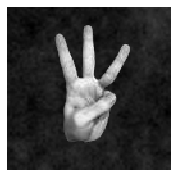

In [115]:
def plot_image(image):
    size = int(math.sqrt(len(image)))
    image_view = image.reshape(size,size)
    plt.imshow(image_view, cmap = mpl.cm.gray);
    plt.axis("off")

randidx = random.randint(0,len(train))
image = train.loc[randidx,'image']
print(train.loc[randidx,:])
plt.figure(figsize=(3,3))
plot_image(image)

Display batch images in a square matrix

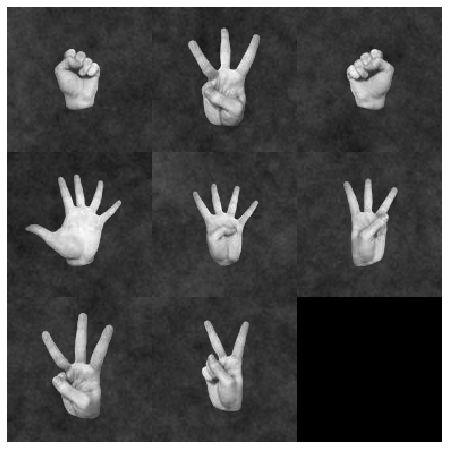

In [116]:
def plot_square_of_images(images):
    size=int(math.sqrt(len(images[0])))
    squaresize = math.ceil(math.sqrt(len(images)))
    im_row = []
    for row in range(squaresize):
        im_col=[]
        for col in range(squaresize):
            if col + squaresize * row < len(images):
                im = images[col + squaresize * row]
                im = im.reshape(size,size)
            else:
                im = np.zeros((size,size))
            im_col.append(im)
        rowofimages = np.concatenate(im_col,axis=1)
        im_row.append(rowofimages)
    squareofimages = np.concatenate(im_row,axis=0)
    flat_squareofimages = squareofimages.flatten()
    plot_image(flat_squareofimages)

sampleidx = sample(range(len(train)),8)
images = train.loc[sampleidx,'image'].reset_index(drop=True)

plt.figure(figsize=(8,8))
plot_square_of_images(images)


### Classic classifiers

### Create train/test sets

In [117]:
xtrain = np.vstack(train['image'])
xtrain.shape

(2000, 16384)

In [118]:
from sklearn.preprocessing import LabelEncoder

ytrain = train['hand']

encoderhand = LabelEncoder()
ytrain = encoderhand.fit_transform(ytrain)

ytrain.shape

y2train = train['nbfinger']

# no need as already numericvalue
# encoderfinger = LabelEncoder()
# y2train = encoderfinger.fit_transform(y2train)

y2train.shape

(2000,)

In [119]:
xtest = np.vstack(test['image'])

In [120]:
ytest = train['hand']
ytest = encoderhand.fit_transform(ytest)
y2test = train['nbfinger']
# y2test = encoderfinger.fit_transform(ytest)

In [121]:
# no need to scale x ??? check
# is it better to scale after PCA ?

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# scaler.fit(xtrain)

# xtrain_s = scaler.transform(xtrain)
# xtest_s = scaler.transform(xtest)

xtrain_s = xtrain
xtest_s = xtest

xtrain_s[0]

array([54, 53, 51, ..., 65, 68, 70], dtype=uint8)

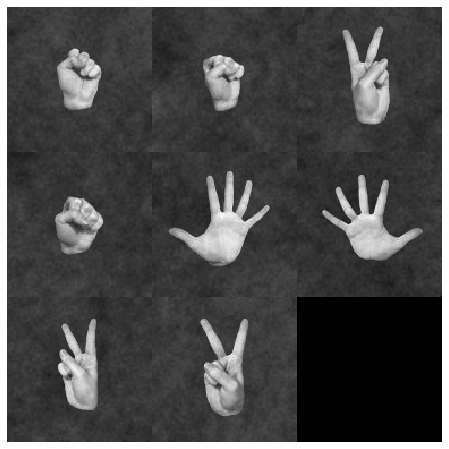

In [122]:
images = xtrain_s[:8]

plt.figure(figsize=(8,8))
plot_square_of_images(images)

### PCA to speedup classifier training (keeping 95% of variance)

In [123]:
# very long on full training dataset 18000 instances. ~13minutes !
# may need to preprocess images before
# or use another PCA method: try incremental PCA

from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(xtrain_s)
t2 = time.time()
t2-t1

7.809403896331787

In [124]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 16384 to 336 after PCA preserving 95% of variance


In [125]:
from sklearn.decomposition import IncrementalPCA
t1 = time.time()
pca = IncrementalPCA(n_components=250,batch_size=1000)
X_reduced = pca.fit_transform(xtrain_s)
t2 = time.time()
t2-t1

5.98133111000061

Check how images looks like after inverse transform with PCA

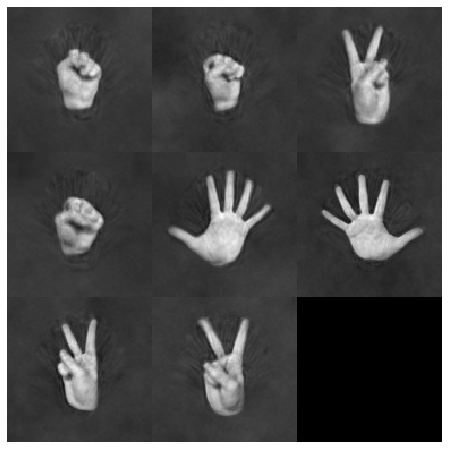

In [126]:
images = pca.inverse_transform(X_reduced[:8])

plt.figure(figsize=(8,8))
plot_square_of_images(images)

### Train some classifiers to make first evaluation

In [127]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t\t',
               ]

# Apply different classifiers

t0 = time.time()
for name, clf in zip(classif_names, classifs):
    t1 = time.time()
    score = cross_val_score(clf, X_reduced, ytrain, cv=3, scoring="accuracy")
    t2 = time.time()    
    print("%.2f seconds - %s Score :" % ((t2-t1),name),score)

print('classifiers trained in %.2f seconds for %d instances' %((t2 - t0),len(xtrain_s)))

#     classifier = clf.fit(xtrain_s, ytrain)
#     ypred = classifier.predict(xtest_s)
#     score1 = classifier.score(xtest_s, ytest)*100
#     score2 = accuracy_score(ypred,ytest)*100
#     print("%s Score : %.2f %% %.2f" % (name, score1,score2))


0.03 seconds - SGD		 Score : [0.99550225 0.98050975 0.98198198]
0.97 seconds - KNN		 Score : [0.99850075 0.994003   0.996997  ]
0.57 seconds - DecisionTree	 Score : [0.93103448 0.89505247 0.8993994 ]
0.76 seconds - SVC		 Score : [1.        1.        0.9984985]
2.55 seconds - RandomForest	 Score : [0.988006   0.982009   0.98198198]
4.09 seconds - AdaBoost		 Score : [0.95052474 0.94602699 0.94744745]
classifiers trained in 8.97 seconds for 2000 instances


**--> SGD seems to bring very good results in significantly less time --> keep this one**

#### LEFT/RIGHT Hand

In [133]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, ytrain, cv=5, scoring="accuracy")

score.min()

0.9725

#### Nb of fingers

In [129]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(random_state=37)
score = cross_val_score(clf, X_reduced, y2train, cv=5, scoring="accuracy")

score.min()

0.9825

### Confusion Matrix

#### LEFT/RIGHT Hand

In [134]:
from sklearn.model_selection import cross_val_predict

ytrain_pred = cross_val_predict(clf, X_reduced, ytrain, cv=3)

confmatr = pd.crosstab(encoderhand.inverse_transform(ytrain), encoderhand.inverse_transform(ytrain_pred), rownames=['True'], colnames=['Predicted'], margins=True)

confmatr

Predicted,L,R,All
True,,,
L,984,19,1003
R,9,988,997
All,993,1007,2000


Check miscategorized pictures

In [135]:
cl_R = 'R'
cl_L = 'L'

LR = X_reduced[(encoderhand.inverse_transform(ytrain) == cl_L) & (encoderhand.inverse_transform(ytrain_pred) == cl_R)]
RL = X_reduced[(encoderhand.inverse_transform(ytrain) == cl_R) & (encoderhand.inverse_transform(ytrain_pred) == cl_L)]

Left hand classifed as Right Hand


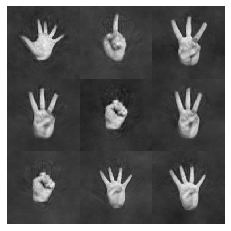

Right hand classifed as Left Hand


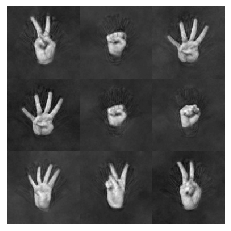

In [136]:
print('Left hand classifed as Right Hand')
plot_square_of_images(pca.inverse_transform(LR[:9]))
plt.show()
print('Right hand classifed as Left Hand')
plot_square_of_images(pca.inverse_transform(RL[:9]))
plt.show()

#### Nb of fingers

In [137]:
ytrain_pred2 = cross_val_predict(clf, X_reduced, y2train, cv=3)

confmatr2 = pd.crosstab(y2train, ytrain_pred2, rownames=['True'], colnames=['Predicted'], margins=True)

In [138]:
confmatr2

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,341,0,0,0,0,0,341
1,5,308,3,1,0,1,318
2,1,5,353,6,0,0,365
3,0,1,9,305,0,0,315
4,0,0,0,0,326,0,326
5,0,0,0,0,1,334,335
All,347,314,365,312,327,335,2000


Check miscategorized pictures

In [139]:
cl32 = X_reduced[(y2train == '3') & (ytrain_pred2 == '2')]
cl21 = X_reduced[(y2train == '2') & (ytrain_pred2 == '1')]

3 fingers classifed as 2


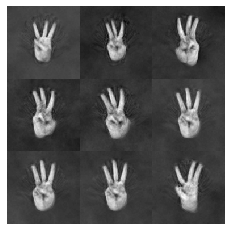

2 fingers classifed as 1


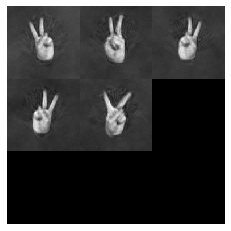

In [140]:
print('3 fingers classifed as 2')
plot_square_of_images(pca.inverse_transform(cl32[:9]))
plt.show()
print('2 fingers classifed as 1')
plot_square_of_images(pca.inverse_transform(cl21[:9]))
plt.show()